In [2]:
import numpy as np
# Set parameters
sigma = 0.3
r_ = -0.3
drift = r_ - 0.5 * sigma**2
T = 1
m = 100
delta_t = T / m
S_0 = 100
N = 1000000 # number of simulations
# Number of RV we simulate is N * m
from scipy.special import zeta
B_1 = -zeta(0.5)/np.sqrt(2 * np.pi)

In [78]:
# Generate paths, note we skip time 0
def simProbMax0(drift, delta_t, sigma, N, m):
    sims = cp.zeros((N, m+1), dtype="float32")
    sims[:, 1:] = cp.random.normal(drift * delta_t, sigma * delta_t**0.5, (N,m)) # note scale param is sd not var
    paths = cp.cumsum(sims, axis=1)
    res = cp.any(paths > 0, axis=1)
    return (cp.sum(~res) / N).get()

# Sanity check they are equivalent (they are)
def simProbMax02(r_, sigma, T, N, m):
    delta_t = T / m
    drift = r_ - 0.5 * sigma**2
    sims = np.zeros((N, m+1), dtype="float32")
    sims[:, 1:] = np.random.normal(drift * delta_t, sigma * delta_t**0.5, (N,m)) # note scale param is sd not var
    paths = np.cumsum(sims, axis=1)
    max_bm = np.max(paths, axis=1)
    res = max_bm > 0
    return np.sum(~res) / N

print(simProbMax0(drift, delta_t, sigma, N, m), simProbMax02(r_, sigma, T, N, m))
prob = simProbMax0(drift, delta_t, sigma, N, m)
sd = (prob * (1 - prob) / N)**0.5
print(f"Probability of maximum 0 is about {prob}, with sd {sd}")
print(f"Hence 95% CI: [{prob - 1.96 * sd}, {prob + 1.96 * sd}")

0.05292 0.10911
Probability of maximum 0 is about 0.05224, with sd 0.000703640408163147
Hence 95% CI: [0.05086086480000023, 0.05361913519999977


In [4]:
from scipy.special import zeta, factorial
#Solution of the probability using the theory of Johans paper thm 2.1 (not rewritten) redone later
def exactProbMax0InfTime(drift):
    B = - drift # this is beta
    r_values = np.arange(0, 1)
    zeta_vals = zeta(0.5 - r_values)
    summation = np.sum(zeta_vals/(factorial(r_values)*(2*r_values+1)) * (-B**2 /2)**r_values)
    return np.exp(B / np.sqrt(2 * np.pi) * summation) * np.sqrt(2) * B
prob_exact = exactProbMax0InfTime(drift/sigma * np.sqrt(T/m))
print(prob_exact)

0.15209526158311007


In [9]:
# Now we will estimate B2 of the paper Broadie 1999
# TODO research errors, sigma and T are fine, very high drift is also off
sigma = 0.5
T = 1
m = 2000
M = 1000000 # this is BM path, above is discrete
N = 1000

drift = 0.1 # Happens when r = 0.5 sigma^2
delta_t = T / M
def estB1B2():
    draws = np.random.normal(drift * delta_t, sigma * delta_t**0.5, (N, M))
    draws = np.c_[np.zeros(N), draws]
    BM_path = np.cumsum(draws, axis=1)
    max_bm = np.max(BM_path, axis=1)
    watch_moments = range(0, M, M//m)
    max_bw = np.max(BM_path[:, watch_moments], axis=1)
    z = BM_path[:, watch_moments]
    B_1_est = m**0.5 * np.mean(max_bm-max_bw)/(sigma * T**0.5)
    B_2_est = m*np.mean((max_bm - max_bw)**2)/(sigma**2 * T)
    return B_1_est, B_2_est
# print(np.sum((max_bw == max_bm))) # too much I think
# print(np.sum(((max_bw == max_bm) & (max_bm != 0)))) # too much I think
print("Beta 1 should be 0.5826 and Beta 2 0.425")
B_1_est, B_2_est = estB1B2()
print(f"Beta 1: {B_1_est}, ")#{np.std(max_bm- max_bw)/(N**0.5)}")
print(f"Beta 2: {B_2_est}")

Beta 1 should be 0.5826 and Beta 2 0.425
Beta 1: 0.5702285311519713, 
Beta 2: 0.43165433009653315


In [142]:
# Here we will use control variates and estimate the constant c
from scipy.special import zeta
B_1 = -zeta(0.5)/np.sqrt(2 * np.pi)
estimates = np.zeros((1500,2))
for i in range(1500):
    estimates[i] = estB1B2()

In [17]:
#Some estimates in finding B2
from scipy.special import zeta
B_1 = -zeta(0.5)/np.sqrt(2 * np.pi)
weirdConstant = zeta(-0.5) / np.sqrt(2 * np.pi)
print(B_1**2)
true_est = B_1**2 - 1/4
B_2 = 0.425
print("Covariance should be ", (B_2 - (B_1**2-1/4))*-1/2 )
print(1/true_est)
print(.425 / true_est)
print(0.425 - true_est)
print(1/(4 * B_1))

0.33941944843861255
Covariance should be  -0.16779027578069372
11.183249477170632
4.752881027797518
0.33558055156138744
0.4291129755668518


In [4]:
import cupy as np
# Poging om covariance(M, Mhat-M) te vinden (partieel geslaagd, het zou kunnen)
drift = -0.000001
m = 3000
M = 3000000 # this is BM path, above is discrete
N = 20
NumberOfSims = 100000
max_bm = np.zeros(N * NumberOfSims, dtype="float32")
max_bw = np.zeros(N*NumberOfSims, dtype="float32")
draws = np.zeros((N,M+1))
for i in range(NumberOfSims):
    draws[:, 1:] = np.random.normal(drift * (m/M), (1/(M/m)**0.5), (N, M))
    BM_path = np.cumsum(draws, axis=1)
    max_bm[i * N:(i+1)*N] = np.max(BM_path, axis=1)
    max_bw[i * N:(i+1)*N] = np.max(BM_path[:, 0:M:M//m], axis=1)
    if i % 100 == 0:
        print(i)
print(np.cov(max_bm, max_bw - max_bm))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [1]:
np.save("max_bm", max_bm)
np.save("max_bw", max_bw)

NameError: name 'np' is not defined

In [20]:
max_bm = np.load("max_bm.npy")
max_bw = np.load("max_bw.npy")
print(np.cov(max_bm, max_bw - max_bm))
print(np.mean(max_bm))
print(np.mean(max_bw - max_bm))
print(np.mean((max_bw - max_bm)**2))
np.mean((max_bm-(43.7))*((max_bw-max_bm)+B_1))
print(B_1**2/2 - 1/4/2-0.425/2)

[[ 1.09005180e+03 -2.47164598e-01]
 [-2.47164598e-01  9.13601453e-02]]
43.700924
-0.56760234
0.41353258
-0.16779027578069372


In [ ]:
#test
import cupy as np
import cupy
import cupy.cuda.cutensor
import cupy.cuda.cudnn
print(cupy.cuda.cutensor.available, cupy.cuda.cudnn.available)

# cupy.show_config()

True True


In [5]:
covariances = np.cov(estimates[:,0], estimates[:,1])
c = -covariances[0,1]/covariances[0,0]
print(np.corrcoef(estimates[:,0], estimates[:,1]))

NameError: name 'estimates' is not defined

In [5]:
# Check formula for maximum geometric brownian motion on finite time
from scipy.stats import norm
import cupy as cp
sigma = 0.2
r_ = 0.1
drift = r_ - 0.5 * sigma**2
T = 1
m = 1000
delta_t = T / m
N = 100000 # number of simulations

def simMeanMaxGBM(drift, sigma, T, N, m):
    delta_t = T / m
    sims = cp.zeros((N, m+1), dtype="float32")
    sims[:, 1:] = cp.random.normal(drift * delta_t, sigma * delta_t**0.5, (N,m)) # note scale param is sd not var
    paths = cp.cumsum(sims, axis=1)
    max_bm = cp.max(paths, axis=1)
    return cp.mean(cp.exp(max_bm)), cp.exp(max_bm)

mean_max_gbm = simMeanMaxGBM(drift, sigma, T, N, m)
print(mean_max_gbm)

def exactMeanMaxGBM(r_, sigma, T):
    return (1 + sigma**2 / (2*r_)) * np.exp(r_*T) * norm.cdf((r_ + 0.5 * sigma**2)*T/(sigma * T**0.5)) + \
        norm.cdf(- (r_ - 0.5 * sigma**2) * T / (sigma*T**0.5)) * (1 - sigma**2 / (2 * r_))
print(exactMeanMaxGBM(r_, sigma, T))

C:\Users\Wouter\anaconda3\envs\simulations\lib\site-packages\cupy\_environment.py:213: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  warnings.warn(


(array(1.2339714, dtype=float32), array([1.1371595, 1.0556613, 1.4453328, ..., 1.0217162, 1.1043687,
       1.080204 ], dtype=float32))
1.238151824487769


In [5]:
# Prob of tildeM_m = 0 and hatM exact via Johan et al, we shall calculate both and compare
sigma = 0.1
r_ = -0.1
drift = r_ - 0.5 * sigma**2
T = 100
m = 5000
delta_t = T / m
N = 100000 # number of simulations

print(exactProbMax0InfTime(drift / sigma * np.sqrt(T / m)))
print(simProbMax0(drift, T/m, sigma, N, m))

0.19260500900844582
0.19259


In [6]:
# Here we will calculate an approximation for the mean of e^tilde(M)_m
S_0 = 100
approx_mean = S_0 * np.exp(- B_1 * sigma * np.sqrt(T / m)) * exactMeanMaxGBM(r_, sigma, T) + exactProbMax0InfTime(r_, sigma, T, m) * S_0
approx_price_option = np.exp(- r_ * T) * (approx_mean - S_0 * np.exp(r_ * T))
print("approx without full correction: ", np.exp(-r_ * T) * S_0 * np.exp(- B_1 * sigma * np.sqrt(T / m)) * exactMeanMaxGBM(r_, sigma, T) - S_0)
def simPriceLookbackPut(r_, sigma, T, N, m):
    drift = r_ - 0.5 * sigma ** 2
    mean_GBM = simMeanMaxGBM(drift, sigma, T, N, m)
    return np.exp(-r_ * T) * (mean_GBM * S_0 - S_0 * np.exp(r_ * T))

print(approx_price_option)
print(simPriceLookbackPut(r_, sigma, T, N, m))

TypeError: exactProbMax0InfTime() takes 1 positional argument but 4 were given

In [90]:
# Here we will numerically integrate my own idea, with the correction added later
from scipy.stats import norm
import scipy.integrate as integrate
from scipy.special import zeta, factorial
import numpy as np
import cupy as cp

def toIntegrate(x, r_, sigma, T, m):
    drift = r_ - 1/2 * sigma**2
    def pdf(x):
        sqrtSigmaT = sigma * T**0.5
        return 1/sqrtSigmaT * norm.pdf((x - drift*T)/sqrtSigmaT) - 2 * drift / sigma**2 * np.exp(2 * drift*x / sigma**2) * norm.cdf((-x - drift * T)/sqrtSigmaT) +\
            np.exp(2 * drift * x / sigma**2) * norm.pdf((-x - drift * T)/sqrtSigmaT)/sqrtSigmaT
    def otherPdf(x):
        return 2 / (sigma * np.sqrt(2 * np.pi * T)) * np.exp(-1/(2 * sigma**2 * T) * (x-drift*T)**2) -\
            2 * drift/ sigma**2 * np.exp(2 * drift * x/ sigma**2)*norm.cdf((-x-drift*T)/(sigma * T**0.5))
    return x * pdf(np.log(x) + B_1 * sigma * np.sqrt(T/m) - np.log(S_0)) / x

def simProbMax0(r_, sigma, T, N, m):
    drift = r_ - 1/2 * sigma**2
    delta_t = T / m
    sims = cp.zeros((N, m+1), dtype="float32")
    sims[:, 1:] = cp.random.normal(drift * delta_t, sigma * delta_t**0.5, (N,m)) # note scale param is sd not var
    paths = cp.cumsum(sims, axis=1)
    res = cp.any(paths > 0, axis=1)
    return (cp.sum(~res) / N).get()

#Solution of the probability using the theory of Johans paper thm 2.1 (not rewritten) redone later
def exactProbMax0InfTime(r_, sigma, T, m):
    import numpy as np
    drift = r_ - 1/2 * sigma**2
    if drift >= 0:
        raise Exception("drift is larger or equal to 0, not allowed")
    B = - (drift / sigma) * np.sqrt(T/m) # this is beta
    r_values = np.arange(0, 150)
    zeta_vals = zeta(0.5 - r_values)
    summation = np.sum(zeta_vals/(factorial(r_values)*(2*r_values+1))* (-1)**r_values * (B**2 /2)**r_values)
    return np.exp(B / np.sqrt(2 * np.pi) * summation) * np.sqrt(2) * B

def own_first_order_approx_MC(S_0, r_, sigma, T, N, m):
    result = integrate.quad(toIntegrate, S_0, np.inf, args=(r_, sigma, T, m))[0]
    return np.exp(-r_ * T) * (result + S_0 * simProbMax0(r_, sigma, T, N, m)) - S_0

def own_first_order_approx_inf_horizon(S_0, r_, sigma, T, m):
    result = integrate.quad(toIntegrate, S_0, np.inf, args=(r_, sigma, T, m))[0]
    return np.exp(-r_ * T) * (result + S_0 * exactProbMax0InfTime(r_, sigma, T, m)) - S_0
r_ = -0.1
#print(own_first_order_approx_inf_horizon(S_0, r_, sigma, T, m))
print(own_first_order_approx_MC(S_0, r_, sigma, T, N, m))
print(sim_price_lookback_put(S_0, r_, sigma, T, N, m))

# Another check, the following results in the same price as approx without fully correction above (as expected)
# result = integrate.quad(toIntegrate, S_0 * np.exp(-B_1 * sigma * np.sqrt(T/m)), np.inf)[0]



84.5098150913444
(array(81.64815655), array([1.0548731, 1.0946639, 1.4165096, ..., 1.8190792, 1.2199577,
       1.4677788], dtype=float32))


In [62]:
# Kansloze pogingen om B_2 te ontleden
gamma = -0.0000001
N = 100
m = 2000
M = m * 1000 # BM path is watched 100 times more than BW path
draws = np.random.normal(gamma, np.sqrt(1/(M/m)), (N, M))
draws = np.c_[np.zeros(N), draws]
BM_path = np.cumsum(draws, axis=1)
max_bm = np.max(BM_path, axis=1)
watch_moments = range(0, M, M//m)
max_bw = np.max(BM_path[:, watch_moments], axis=1)
print(np.mean((max_bm - max_bw)**2))


0.39067272328167396
[[ 6.56412421e+02 -2.91495324e-01]
 [-2.91495324e-01  8.65849801e-02]]


In [8]:
from scipy.special import zeta
import cupy as cp # change code to use cp
from scipy.stats import norm
import math

B_1 = - zeta(0.5) / (2 * np.pi)**0.5
def exact_price_cont_time(S_0, r_, sigma, T): # Checked with broadie paper
    return np.exp(-r_*T) * exactMeanMaxGBM(r_, sigma, T) * S_0 - S_0

# print(exact_price_cont_time(100, 0.1, 0.3, 0.5)) # sanity check with Broadie

def broadie_first_order_approx(S_0, r_, sigma, T, m): # checked with broadie
    v = exact_price_cont_time(S_0, r_, sigma, T)
    return (v + S_0) * np.exp(-B_1 * sigma * (T/m)**0.5) - S_0

# print(broadie_first_order_approx(100, 0.1, 0.3, 0.5, 5)) # Sanity check with broadie

def g(t, mu, T, sigma):
    return mu * T**0.5 / sigma * norm.cdf(mu * (T*t)**0.5/sigma) + \
           1 / np.sqrt(2 * np.pi * t) * np.exp(- mu**2 * T * t/(2 * sigma**2))


# todo add that we can add multiple extra terms for diff in mean M and M_tilde
def broadie_second_order_approx(S_0, r_, sigma, T, m):
    v = exact_price_cont_time(S_0, r_, sigma, T)
    mu = r_ - 0.5 * sigma**2
    B_2 = 0.425
    term = 1 - B_1 * sigma * T**0.5/m**0.5 + (2*g(1, mu, T, sigma) * sigma * T**0.5 - mu * T + 2 * B_2 * sigma**2 * T)/ (4*m)
    return (v + S_0) * term - S_0

# print(broadie_second_order_approx(100, 0.1, 0.3, 0.5, 5)) # Sanity check with broadie, note I use the representation of my paper but answers are equivalent

def sim_price_lookback_put(S_0, r_, sigma, T, N, m):
    drift = r_ - 0.5 * sigma ** 2
    sims_done = 0
    max_gbws = cp.array([], dtype="float32")
    while sims_done < N:
        N_step = cp.min(np.array([100000000//m, N - sims_done])).item()
        mean_GBM, max_gbw = simMeanMaxGBM(drift, sigma, T, N_step, m)
        max_gbws = cp.concatenate((max_gbws, max_gbw))
        sims_done += N_step
    return cp.exp(-r_ * T) * cp.mean(max_gbws) * S_0 - S_0, max_gbws

mean, max_gbw = sim_price_lookback_put(100, 0.1, 0.3, 0.5, 10000000, 7)
print(mean, np.mean(max_gbw), np.exp(-0.1*0.5) * 100 * np.std(max_gbw) / np.sqrt(10000000))

x_points = np.arange(1, 101)
sims = np.zeros((x_points.size, 4))
r_ = 0.1
sigma = 0.3
T = 0.5
# from timeit import default_timer as timer # Time simulations
# start = timer()
# sim_price_lookback_put(100, r_, sigma, T, 100000000, 100)
# end = timer()
# print("Time", end - start) # Time in seconds, e.g. 5.38091952400282
# for i in range(0, x_points.size):
#     m = i+1
#     sims[i,:] = np.array([exact_price_cont_time(100, r_, sigma, T), broadie_first_order_approx(100, r_, sigma, T, m)
#         , broadie_second_order_approx(100, r_, sigma, T, m), sim_price_lookback_put(100, r_, sigma, T, 10000000, m)[0]])

10.748089280742136 1.1642627 0.0050211265


In [144]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
sims = cp.asnumpy(sims)
x_points = cp.asnumpy(x_points)
plt.plot(x_points, sims[:, 0], label="Continuous time")
plt.plot(x_points, sims[:, 1], label="First order approximation")
plt.plot(x_points, sims[:, 2], label="Second order approximation")
plt.plot(x_points, sims[:, 3], label="Monte-carlo simulations")

plt.xlabel("m")
plt.ylabel("price")
plt.title("Prices of different approximations")
plt.legend()
plt.grid()
plt.show()
plt.savefig('histogram.pgf')

print(sims[79])

<ipython-input-144-d465f421f736>:22: UserWarning: Matplotlib is currently using pgf, which is a non-GUI backend, so cannot show the figure.
  plt.show()


ValueError: Error processing '\(\displaystyle {−20}\)'
LaTeX Output:

! Package inputenc Error: Unicode character − (U+2212)
(inputenc)                not set up for use with LaTeX.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
<*> ...0000}\selectfont \(\displaystyle {−20}\)}
                                                  
!  ==> Fatal error occurred, no output PDF file produced!
Transcript written on texput.log.


In [41]:
import pandas as pd
# Table of every 20 points, note first point is m = 1
print(sims[39])
m_points = cp.array(range(19,100,20))
m_points = cp.asnumpy(m_points)
print(sims[m_points, 1:])
df = pd.DataFrame(np.round(sims[m_points, 1:], 5), index=m_points+1, columns=["First order", "Second order"
                                                                ,"Monte-carlo"])
df = df.rename_axis("m")
df.columns.name = df.index.name
df.index.name = None  # Makes m align with the column names
print(df)

df.to_latex('differentPricesTable.tex')


[15.35255547 13.12034315 13.24908913 13.23602936]
[[12.20843054 12.46603994 12.44172872]
 [13.12034315 13.24908913 13.23602936]
 [13.52670075 13.61251401 13.60421283]
 [13.76963219 13.83398434 13.83513119]
 [13.93571506 13.98719253 13.98795415]]
m   First order Second order Monte-carlo
20     12.20843     12.46604    12.44173
40     13.12034     13.24909    13.23603
60      13.5267     13.61251    13.60421
80     13.76963     13.83398    13.83513
100    13.93572     13.98719    13.98795


In [92]:
# Code written for export (almost)
# Generates the plots for different first order approximations
from scipy.stats import norm
import scipy.integrate as integrate
from scipy.special import zeta, factorial
import numpy as np
import cupy as cp

def toIntegrate(x, r_, sigma, T, m):
    drift = r_ - 1/2 * sigma**2
    def pdf(x):
        sqrtSigmaT = sigma * T**0.5
        return 1/sqrtSigmaT * norm.pdf((x - drift*T)/sqrtSigmaT) - 2 * drift / sigma**2 * np.exp(2 * drift*x / sigma**2) * norm.cdf((-x - drift * T)/sqrtSigmaT) +\
            np.exp(2 * drift * x / sigma**2) * norm.pdf((-x - drift * T)/sqrtSigmaT)/sqrtSigmaT
    def otherPdf(x):
        return 2 / (sigma * np.sqrt(2 * np.pi * T)) * np.exp(-1/(2 * sigma**2 * T) * (x-drift*T)**2) -\
            2 * drift/ sigma**2 * np.exp(2 * drift * x/ sigma**2)*norm.cdf((-x-drift*T)/(sigma * T**0.5))
    return x * pdf(np.log(x) + B_1 * sigma * np.sqrt(T/m) - np.log(S_0)) / x

def simProbMax0(r_, sigma, T, N, m):
    drift = r_ - 1/2 * sigma**2
    delta_t = T / m
    sims = cp.zeros((N, m+1), dtype="float32")
    sims[:, 1:] = cp.random.normal(drift * delta_t, sigma * delta_t**0.5, (N,m)) # note scale param is sd not var
    paths = cp.cumsum(sims, axis=1)
    res = cp.any(paths > 0, axis=1)
    return (cp.sum(~res) / N).get()

#Solution of the probability using the theory of Johans paper thm 2.1 (not rewritten) redone later
def exactProbMax0InfTime(r_, sigma, T, m):
    drift = r_ - 1/2 * sigma**2
    if drift >= 0:
        raise Exception("drift is larger or equal to 0, not allowed")
    B = - (drift / sigma) * np.sqrt(T/m) # this is beta
    r_values = np.arange(0, 150)
    zeta_vals = zeta(0.5 - r_values)
    summation = np.sum(zeta_vals/(factorial(r_values)*(2*r_values+1))* (-1)**r_values * (B**2 /2)**r_values)
    return np.exp(B / np.sqrt(2 * np.pi) * summation) * np.sqrt(2) * B

def own_first_order_approx_MC(S_0, r_, sigma, T, N, m):
    result = integrate.quad(toIntegrate, S_0, np.inf, args=(r_, sigma, T, m))[0]
    return np.exp(-r_ * T) * (result + S_0 * simProbMax0(r_, sigma, T, N, m)) - S_0

def own_first_order_approx_inf_horizon(S_0, r_, sigma, T, m):
    result = integrate.quad(toIntegrate, S_0, np.inf, args=(r_, sigma, T, m))[0]
    return np.exp(-r_ * T) * (result + S_0 * exactProbMax0InfTime(r_, sigma, T, m)) - S_0
print(own_first_order_approx_inf_horizon(S_0, r_, sigma, T, m))
print(own_first_order_approx_MC(S_0, r_, sigma, T, N, m))
print(sim_price_lookback_put(S_0, r_, sigma, T, N, m))

# Another check, the following results in the same price as approx without fully correction above (as expected)
# result = integrate.quad(toIntegrate, S_0 * np.exp(-B_1 * sigma * np.sqrt(T/m)), np.inf)[0]
# print(exact_price_cont_time(S_0, r_, sigma, T), np.exp(-r_*T) * integrate.quad(toIntegrate, S_0, np.inf, args=(r_, sigma, T, 10**10))[0] - S_0)
print(np.exp(-r_*T) * integrate.quad(toIntegrate, S_0 * np.exp(-B_1 * sigma * np.sqrt(T/m)), np.inf, args=(r_, sigma, T, m))[0] - S_0)
print(np.exp(-r_*T) * integrate.quad(toIntegrate, S_0 * np.exp(-B_1 * sigma * np.sqrt(T/m)), np.inf, args=(r_, sigma, T, m))[0] - S_0)

81.79885641561933
84.22156404041863
(array(81.87614103), array([2.1098793, 1.05095  , 1.1419275, ..., 1.       , 1.0967499,
       1.5112722], dtype=float32))
81.88852908396669
81.88852908396669


In [18]:
r_ = -0.005
sigma = 0.3
T = 0.5
S_0 = 100
x_points = cp.arange(1, 101)
sims = cp.zeros((x_points.size, 4))
for i in range(0, x_points.size):
    m = i+1
    sims[i,:] = cp.array([own_first_order_approx_inf_horizon(S_0, r_, sigma, T, m), own_first_order_approx_MC(S_0, r_, sigma, T, 1000000, m)
        , broadie_first_order_approx(S_0, r_, sigma, T, m), sim_price_lookback_put(S_0, r_, sigma, T, 10000000, m)[0]], dtype="float32")
sims = cp.asnumpy(sims)
x_points = cp.asnumpy(x_points)
np.save("firstOrderApproximations", sims)
np.save("x_pointsfirstOrderApproximations", x_points)

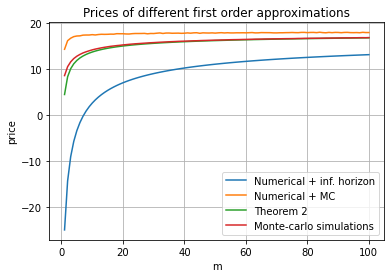

In [19]:
sims = np.load("firstOrderApproximations.npy")
x_points = np.load("x_pointsfirstOrderApproximations.npy")
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })
plt.plot(x_points, sims[:, 0], label="Numerical + inf. horizon")
plt.plot(x_points, sims[:, 1], label="Numerical + MC")
plt.plot(x_points, sims[:, 2], label="Theorem 2")
plt.plot(x_points, sims[:, 3], label="Monte-carlo simulations")

plt.xlabel("m")
plt.ylabel("price")
plt.title("Prices of different first order approximations")
plt.legend()
plt.grid()

plt.show()
# plt.savefig('firstOrderApproximations.pgf')

In [68]:
# first order approximations with different parameters

r_ = -0.1
sigma = 0.5
T = 2
S_0 = 100
x_points = cp.arange(1, 101)
sims = cp.zeros((x_points.size, 4))
for i in range(0, x_points.size):
    m = i+1
    sims[i,:] = cp.array([own_first_order_approx_inf_horizon(S_0, r_, sigma, T, m), own_first_order_approx_MC(S_0, r_, sigma, T, 1000000, m)
        , broadie_first_order_approx(S_0, r_, sigma, T, m), sim_price_lookback_put(S_0, r_, sigma, T, 10000000, m)[0]], dtype="float32")
sims = cp.asnumpy(sims)
x_points = cp.asnumpy(x_points)
np.save("firstOrderApproximationsPic2", sims)
np.save("x_pointsfirstOrderApproximationsPic2", x_points)

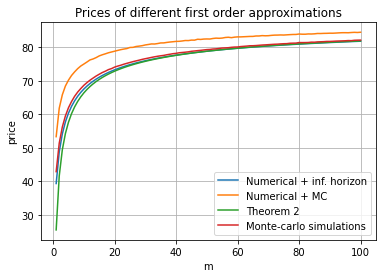

In [69]:
sims = np.load("firstOrderApproximationsPic2.npy")
x_points = np.load("x_pointsfirstOrderApproximationsPic2.npy")
import matplotlib.pyplot as plt
import matplotlib
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })
plt.plot(x_points, sims[:, 0], label="Numerical + inf. horizon")
plt.plot(x_points, sims[:, 1], label="Numerical + MC")
plt.plot(x_points, sims[:, 2], label="Theorem 2")
plt.plot(x_points, sims[:, 3], label="Monte-carlo simulations")

plt.xlabel("m")
plt.ylabel("price")
plt.title("Prices of different first order approximations")
plt.legend()
plt.grid()

plt.show()
# plt.savefig('firstOrderApproximations.pgf')
